# Car Classify

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

## load data
pandas dataframe
dfclass, dftrain, dftest

In [5]:
dfclass = pd.read_csv('class.csv')

In [6]:
dfclass.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [7]:
dftest = pd.read_csv('test.csv')
dftest.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [8]:
dftrain = pd.read_csv('train.csv')
dftrain.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [23]:
dftrain.shape, dftest.shape, dfclass.shape

((9990, 6), (6150, 5), (196, 2))

In [24]:
print(dftrain.count(), dftest.count(), dfclass.count())

img_file    9990
bbox_x1     9990
bbox_y1     9990
bbox_x2     9990
bbox_y2     9990
class       9990
dtype: int64 img_file    6150
bbox_x1     6150
bbox_y1     6150
bbox_x2     6150
bbox_y2     6150
dtype: int64 id      196
name    196
dtype: int64


In [10]:
import seaborn as sns

/home/psychic/.conda/envs/tensorgpu36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [12]:
for f in dftest.img_file:
    if not os.path.exists('test/'+f):
        print('not found:', f)

In [13]:
for f in dftrain.img_file:
    if not os.path.exists('train/'+f):
        print('not found:', f)

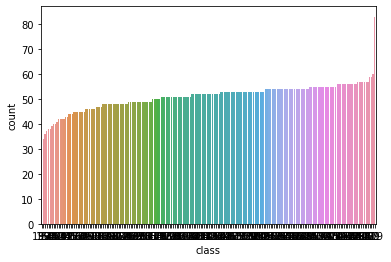

In [17]:
sns.countplot(dftrain["class"], order=dftrain["class"].value_counts(ascending=True).index)

In [18]:
dftrain["class"].value_counts(ascending=True)

136    30
99     34
158    36
64     37
175    38
71     38
2      39
45     40
142    40
10     41
100    42
26     42
134    42
141    42
47     43
42     43
152    44
41     44
27     44
157    45
159    45
150    45
163    45
60     45
12     45
39     45
69     46
49     46
116    46
62     46
       ..
6      55
44     55
1      55
165    55
109    55
43     55
73     55
8      56
148    56
24     56
115    56
194    56
162    56
114    56
72     56
112    56
82     56
81     56
65     56
56     57
144    57
191    57
182    57
98     57
171    57
20     57
167    59
161    59
79     60
119    83
Name: class, Length: 196, dtype: int64

In [19]:
dftrain.describe()


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
count,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,64.450250,108.103103,637.145145,416.097097,99.058358
std,80.943666,106.854930,410.671550,274.215428,56.508850
min,1.000000,1.000000,72.000000,46.000000,1.000000
25%,19.000000,41.000000,390.000000,245.000000,51.000000
50%,39.000000,79.000000,570.000000,361.000000,99.000000
75%,78.000000,137.000000,745.000000,476.000000,148.000000
max,1648.000000,1646.000000,5205.000000,3389.000000,196.000000


## image view

(500, 700, 3)
(266, 355, 3)
(194, 259, 3)


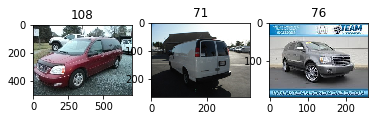

In [60]:
plt.figure()
pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = 'train/'+a
    img = plt.imread(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.imshow(img)
    print(img.shape)

train/train_00001.jpg
(224, 224, 3)
train/train_00002.jpg
(224, 224, 3)
train/train_00003.jpg
(224, 224, 3)


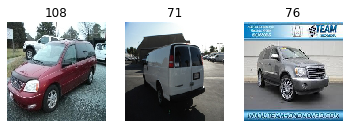

In [81]:
# resize??? (224,224,3)
from PIL import Image
pi=0
for i in range(3):
    a = dftrain.img_file[i]
    imgpath = 'train/'+a
    print(imgpath)
    pi+=1
    plt.subplot(1,3,pi)
    plt.title(dftrain["class"][i])
    plt.axis('off')
    imgobj = Image.open(imgpath)
    imgobj = imgobj.resize((224,224))
    img_r = np.asarray(imgobj)
    plt.imshow(img_r)
    print(img_r.shape)

In [62]:
print(i, img.shape)
print(dftrain.loc[i])
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
print(bb)

2 (194, 259, 3)
img_file    train_00003.jpg
bbox_x1                  35
bbox_y1                  42
bbox_x2                 227
bbox_y2                 160
class                    76
Name: 2, dtype: object
[35, 42, 227, 160]


## bounding box

In [63]:
def bound(img, x1,y1,x2,y2):
    img[y1,x1:x2] = [255,0,0]
    img[y2,x1:x2] = [255,0,0]
    img[y1:y2,x1] = [255,0,0]
    img[y1:y2,x2] = [255,0,0]
    return img


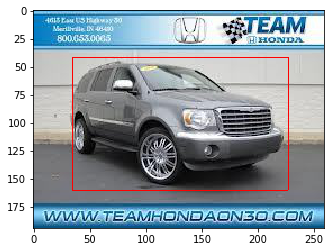

In [64]:
img2 = np.copy(img)
img2=bound(img2, bb[0], bb[1], bb[2], bb[3])
plt.imshow(img2)

In [68]:
# bb, width, height
def resize_bb(bb, w, h):
    rx = 224/w
    ry = 224/h
    return [int(bb[0]*rx), int(bb[1]*ry), int(bb[2]*rx), int(bb[3]*ry)]

bb2=resize_bb(bb, img.shape[1], img.shape[0])
print(bb, bb2)

[35, 42, 227, 160] [30, 48, 196, 184]


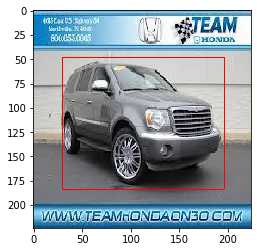

In [69]:
img2 = np.copy(img_r)
img2=bound(img2, bb2[0], bb2[1], bb2[2], bb2[3])
plt.imshow(img2)

## Training dataset preprocessing

image (224,224,3) shape. 3 channels. crop box area.


In [80]:
''' crop and resize '''
def prepro_img(imgpath, bb):
    img = Image.open(imgpath)
    imgn = np.asarray(img)
    imgc = imgn[bb[1]:bb[3], bb[0]:bb[2]]
    print(imgc.shape)
    imgcobj = Image.fromarray(imgc)
    imgcobj2 = imgcobj.resize((224,224))
    newimg = np.asarray(imgcobj2)
    return newimg

In [93]:

# make train data numpy 

cnt_train = dftrain.shape[0]
x_train=[]
y_train=[]
for i in range(cnt_train):
# for i in range(5):
    imgpath = 'train/'+dftrain.loc[i]['img_file']
    bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
    cl = dftrain.loc[i]['class']
    y_train.append(cl)
    # resize
#     print(bb)
    test1 = prepro_img(imgpath, bb)
    x_train.append(test1)
#     plt.figure()
#     plt.imshow(test1)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
print(x_train.shape, y_train.shape)
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
    

(381, 640, 3)
(183, 236, 3)
(118, 192, 3)
(144, 244, 3)
(506, 771, 3)
(663, 834, 3)
(390, 594, 3)
(336, 619, 3)
(117, 247, 3)
(188, 368, 3)
(120, 130)
(116, 283, 3)
(316, 582, 3)
(206, 565, 3)
(287, 579, 3)
(786, 1449, 3)
(166, 232, 3)
(115, 202, 3)
(365, 801, 3)
(195, 447, 3)
(104, 254, 3)
(118, 228, 3)
(176, 315, 3)
(127, 252, 3)
(105, 165, 3)
(454, 517, 3)
(114, 313, 3)
(285, 475, 3)
(491, 952, 3)
(198, 340, 3)
(297, 578, 3)
(834, 1783, 3)
(341, 647, 3)
(124, 230, 3)
(231, 342, 3)
(238, 508, 3)
(363, 442, 3)
(382, 628, 3)
(215, 647, 3)
(532, 883, 3)
(288, 373, 3)
(216, 309, 3)
(210, 517, 3)
(82, 193, 3)
(494, 942, 3)
(216, 428, 3)
(239, 544, 3)
(166, 560, 3)
(255, 566, 3)
(300, 566, 3)
(207, 339, 3)
(441, 780, 3)
(451, 634, 3)
(126, 179, 3)
(69, 213, 3)
(171, 285, 3)
(726, 983, 3)
(729, 1287, 3)
(104, 200, 3)
(431, 806, 3)
(381, 622, 3)
(273, 506, 3)
(209, 287, 3)
(381, 655, 3)
(133, 287, 3)
(147, 288, 3)
(189, 359, 3)
(253, 432, 3)
(551, 958, 3)
(119, 223, 3)
(222, 564, 3)
(208, 42

(681, 1506, 3)
(433, 628, 3)
(161, 184, 3)
(294, 578, 3)
(262, 306, 3)
(152, 291, 3)
(225, 480, 3)
(360, 606, 3)
(242, 386, 3)
(325, 593, 3)
(371, 672, 3)
(129, 214, 3)
(921, 1565, 3)
(538, 715, 3)
(299, 407, 3)
(146, 399, 3)
(306, 532, 3)
(473, 535, 3)
(1910, 2614, 3)
(208, 224, 3)
(219, 531, 3)
(138, 381, 3)
(237, 453, 3)
(369, 545, 3)
(231, 585, 3)
(310, 570, 3)
(417, 691, 3)
(353, 912, 3)
(138, 388, 3)
(1642, 2253, 3)
(379, 609, 3)
(216, 426, 3)
(999, 2770, 3)
(201, 357, 3)
(250, 507, 3)
(160, 265, 3)
(197, 385, 3)
(265, 545, 3)
(104, 155, 3)
(568, 1231, 3)
(288, 570, 3)
(512, 991, 3)
(219, 414, 3)
(105, 247, 3)
(184, 301, 3)
(233, 771, 3)
(338, 542, 3)
(142, 249, 3)
(313, 571, 3)
(353, 764, 3)
(304, 512, 3)
(299, 887, 3)
(219, 440, 3)
(115, 241, 3)
(105, 334, 3)
(224, 498, 3)
(134, 285, 3)
(362, 510, 3)
(165, 263, 3)
(358, 480, 3)
(359, 575, 3)
(406, 620, 3)
(279, 681, 3)
(216, 486, 3)
(304, 470, 3)
(236, 540, 3)
(176, 292, 3)
(218, 428, 3)
(302, 543, 3)
(350, 541, 3)
(117, 229, 3

(198, 520, 3)
(173, 244, 3)
(130, 283, 3)
(403, 586, 3)
(271, 578, 3)
(199, 408, 3)
(307, 604, 3)
(62, 106, 3)
(258, 741, 3)
(224, 262, 3)
(344, 545, 3)
(145, 248, 3)
(76, 135, 3)
(466, 912, 3)
(420, 968, 3)
(144, 242, 3)
(360, 865, 3)
(566, 1001, 3)
(104, 206, 3)
(200, 498, 3)
(266, 443, 3)
(930, 1463, 3)
(244, 442, 3)
(407, 857, 3)
(246, 465, 3)
(245, 487, 3)
(204, 414, 3)
(179, 600, 3)
(274, 432, 3)
(354, 493, 3)
(295, 457, 3)
(149, 265, 3)
(484, 657, 3)
(95, 192, 3)
(245, 366, 3)
(423, 717, 3)
(222, 478, 3)
(353, 614, 3)
(211, 429, 3)
(165, 571, 3)
(404, 630, 3)
(150, 227, 3)
(354, 561, 3)
(678, 1191, 3)
(253, 356, 3)
(476, 946, 3)
(125, 261, 3)
(128, 286, 3)
(753, 1334, 3)
(522, 931, 3)
(246, 539, 3)
(221, 326, 3)
(348, 608, 3)
(236, 412, 3)
(326, 463, 3)
(309, 420, 3)
(277, 587, 3)
(150, 242, 3)
(320, 453, 3)
(306, 560, 3)
(452, 717, 3)
(234, 419, 3)
(274, 561, 3)
(227, 675, 3)
(385, 568, 3)
(191, 227, 3)
(498, 642, 3)
(174, 452, 3)
(306, 528, 3)
(228, 268, 3)
(414, 583, 3)
(653,

(217, 538, 3)
(157, 227, 3)
(382, 491, 3)
(617, 1277, 3)
(438, 518, 3)
(114, 194, 3)
(287, 575, 3)
(139, 242, 3)
(195, 412, 3)
(97, 267, 3)
(135, 246, 3)
(143, 243, 3)
(377, 584, 3)
(147, 275, 3)
(322, 774, 3)
(365, 554, 3)
(693, 1207, 3)
(334, 617, 3)
(260, 425, 3)
(94, 196, 3)
(361, 548, 3)
(288, 620, 3)
(93, 210, 3)
(90, 209, 3)
(441, 760, 3)
(177, 460, 3)
(1570, 2488, 3)
(162, 402, 3)
(101, 191, 3)
(199, 370, 3)
(149, 320, 3)
(478, 1086, 3)
(488, 1309, 3)
(118, 295, 3)
(243, 348, 3)
(327, 549, 3)
(351, 481, 3)
(57, 146, 3)
(203, 488, 3)
(145, 358, 3)
(131, 262, 3)
(297, 465, 3)
(296, 577, 3)
(305, 700, 3)
(169, 316, 3)
(95, 263, 3)
(299, 528, 3)
(230, 460, 3)
(307, 484, 3)
(167, 355, 3)
(363, 519, 3)
(375, 714, 3)
(268, 483, 3)
(390, 937, 3)
(394, 526, 3)
(115, 212, 3)
(134, 240, 3)
(941, 1337, 3)
(256, 583, 3)
(228, 675, 3)
(159, 375, 3)
(84, 199, 3)
(294, 604, 3)
(268, 430, 3)
(234, 431, 3)
(297, 596, 3)
(79, 237, 3)
(121, 209, 3)
(248, 692, 3)
(79, 92, 3)
(403, 499, 3)
(141, 206

(651, 1403, 3)
(275, 303, 3)
(143, 335, 3)
(430, 653, 3)
(500, 915, 3)
(798, 1479, 3)
(123, 225, 3)
(373, 564, 3)
(166, 325, 3)
(113, 228, 3)
(239, 473, 3)
(424, 602, 3)
(112, 225, 3)
(119, 220, 3)
(539, 832, 3)
(453, 908, 3)
(207, 413, 3)
(143, 391, 3)
(339, 491, 3)
(270, 611, 3)
(258, 411, 3)
(324, 582, 3)
(348, 780, 3)
(115, 272, 3)
(92, 207, 3)
(220, 541, 3)
(90, 219, 3)
(137, 253, 3)
(488, 1133, 3)
(222, 406, 3)
(367, 446, 3)
(169, 455, 3)
(430, 661, 3)
(138, 349, 3)
(110, 171, 3)
(269, 382, 3)
(278, 601, 3)
(468, 1004, 3)
(340, 620, 3)
(442, 721, 3)
(235, 390, 3)
(484, 771, 3)
(95, 192, 3)
(315, 367, 3)
(157, 237, 3)
(155, 463, 3)
(254, 524, 3)
(120, 253, 3)
(368, 855, 3)
(686, 1491, 3)
(272, 603, 3)
(537, 851, 3)
(135, 252, 3)
(158, 435, 3)
(318, 524, 3)
(210, 457, 3)
(294, 572, 3)
(553, 933, 3)
(243, 634, 3)
(189, 381, 3)
(107, 158, 3)
(298, 676, 3)
(339, 589, 3)
(111, 204, 3)
(756, 1336, 3)
(58, 113, 3)
(274, 477, 3)
(460, 760, 3)
(375, 953, 3)
(247, 444, 3)
(183, 429, 3)
(310

(222, 512, 3)
(197, 501, 3)
(104, 240, 3)
(116, 242, 3)
(342, 444, 3)
(155, 272, 3)
(224, 295, 3)
(286, 579, 3)
(538, 997, 3)
(348, 572, 3)
(366, 748, 3)
(121, 334, 3)
(229, 319, 3)
(653, 1114, 3)
(349, 596, 3)
(192, 573)
(255, 391, 3)
(210, 577, 3)
(203, 503, 3)
(335, 618, 3)
(514, 870, 3)
(500, 852, 3)
(98, 241, 3)
(422, 581, 3)
(80, 223, 3)
(189, 481, 3)
(133, 240, 3)
(210, 528, 3)
(134, 301, 3)
(107, 160, 3)
(252, 433, 3)
(307, 429, 3)
(233, 684, 3)
(219, 395, 3)
(261, 424, 3)
(375, 599, 3)
(238, 420, 3)
(175, 338, 3)
(109, 246, 3)
(83, 180, 3)
(115, 256, 3)
(195, 256, 3)
(366, 707, 3)
(250, 516, 3)
(214, 542, 3)
(104, 181, 3)
(99, 235, 3)
(156, 226, 3)
(231, 581, 3)
(115, 267, 3)
(434, 607, 3)
(198, 373, 3)
(245, 552, 3)
(254, 478, 3)
(228, 458, 3)
(298, 719, 3)
(157, 458, 3)
(396, 966, 3)
(149, 161, 3)
(234, 583, 3)
(361, 766, 3)
(186, 360, 3)
(194, 353, 3)
(402, 535, 3)
(747, 1137, 3)
(480, 882, 3)
(164, 421, 3)
(102, 182, 3)
(482, 723, 3)
(147, 288, 3)
(1992, 3477, 3)
(113, 178

(1568, 2988, 3)
(186, 458, 3)
(291, 800, 3)
(159, 281, 3)
(130, 245, 3)
(231, 469, 3)
(328, 558, 3)
(340, 550, 3)
(578, 947, 3)
(218, 440, 3)
(59, 123, 3)
(318, 668, 3)
(138, 284, 3)
(1956, 2319, 3)
(179, 477, 3)
(531, 1074, 3)
(107, 207, 3)
(402, 757, 3)
(388, 977, 3)
(349, 622, 3)
(515, 960, 3)
(104, 199, 3)
(388, 851, 3)
(160, 271, 3)
(309, 670, 3)
(737, 1524, 3)
(207, 298, 3)
(206, 353, 3)
(85, 145, 3)
(315, 587, 3)
(508, 722, 3)
(364, 589, 3)
(430, 799, 3)
(344, 372, 3)
(447, 888, 3)
(424, 799, 3)
(371, 518, 3)
(281, 467, 3)
(117, 204, 3)
(721, 1004, 3)
(155, 390, 3)
(92, 229, 3)
(118, 225, 3)
(287, 534, 3)
(75, 185, 3)
(185, 252, 3)
(93, 235, 3)
(110, 291, 3)
(152, 230, 3)
(122, 258, 3)
(505, 758, 3)
(320, 511, 3)
(398, 987, 3)
(374, 538, 3)
(85, 126, 3)
(185, 353, 3)
(78, 136, 3)
(94, 248, 3)
(355, 805, 3)
(550, 981, 3)
(106, 227, 3)
(289, 541, 3)
(136, 213, 3)
(239, 492, 3)
(590, 776, 3)
(206, 417, 3)
(464, 1231, 3)
(130, 223, 3)
(173, 290, 3)
(315, 561, 3)
(939, 1557, 3)
(101,

(614, 972, 3)
(306, 592, 3)
(172, 424, 3)
(464, 880, 3)
(534, 962, 3)
(214, 417, 3)
(162, 292, 3)
(672, 1004, 3)
(233, 438, 3)
(121, 252, 3)
(217, 282, 3)
(129, 291, 3)
(392, 671, 3)
(206, 419, 3)
(206, 376, 3)
(206, 257, 3)
(153, 228, 3)
(950, 1658, 3)
(328, 541, 3)
(70, 210, 3)
(677, 1815, 3)
(712, 1478, 3)
(298, 390, 3)
(128, 231, 3)
(299, 446, 3)
(450, 1412, 3)
(1103, 2716, 3)
(162, 290, 3)
(265, 423, 3)
(230, 469, 3)
(312, 601, 3)
(518, 841, 3)
(138, 345, 3)
(203, 351, 3)
(116, 264, 3)
(509, 864, 3)
(1100, 1891, 3)
(192, 571, 3)
(426, 681, 3)
(235, 497, 3)
(174, 326, 3)
(193, 333, 3)
(439, 854, 3)
(151, 291, 3)
(274, 552, 3)
(286, 557, 3)
(107, 217, 3)
(620, 942, 3)
(340, 595, 3)
(364, 547, 3)
(315, 580, 3)
(319, 718, 3)
(349, 829, 3)
(95, 166, 3)
(229, 423, 3)
(147, 231, 3)
(181, 330, 3)
(220, 398, 3)
(256, 375, 3)
(434, 622, 3)
(451, 997, 3)
(224, 525, 3)
(191, 443, 3)
(268, 494, 3)
(419, 839, 3)
(234, 486, 3)
(139, 194, 3)
(275, 549, 3)
(348, 485, 3)
(208, 446, 3)
(373, 831, 3)

(254, 486, 3)
(222, 366, 3)
(358, 672, 3)
(1713, 2645, 3)
(193, 398, 3)
(309, 527, 3)
(330, 604, 3)
(122, 212, 3)
(169, 417, 3)
(294, 537, 3)
(573, 734, 3)
(215, 363, 3)
(240, 459, 3)
(319, 566, 3)
(249, 476, 3)
(401, 612, 3)
(135, 219, 3)
(199, 385, 3)
(498, 606, 3)
(129, 245, 3)
(181, 391, 3)
(263, 530, 3)
(160, 258, 3)
(345, 760, 3)
(282, 603, 3)
(140, 477, 3)
(125, 228, 3)
(629, 885, 3)
(337, 658, 3)
(279, 389, 3)
(311, 655, 3)
(235, 474, 3)
(261, 584, 3)
(232, 376, 3)
(195, 435, 3)
(296, 422, 3)
(168, 496, 3)
(238, 533, 3)
(104, 303, 3)
(305, 729, 3)
(750, 1615, 3)
(401, 667, 3)
(543, 1416, 3)
(277, 486, 3)
(255, 578, 3)
(354, 577, 3)
(203, 438, 3)
(245, 418, 3)
(144, 267, 3)
(236, 650, 3)
(351, 893, 3)
(197, 436, 3)
(119, 294, 3)
(464, 794, 3)
(267, 408, 3)
(91, 252, 3)
(133, 233, 3)
(451, 903, 3)
(374, 904, 3)
(250, 556, 3)
(290, 444, 3)
(160, 190, 3)
(425, 773, 3)
(199, 297, 3)
(179, 407, 3)
(188, 419, 3)
(184, 376, 3)
(207, 490, 3)
(135, 242, 3)
(266, 590, 3)
(300, 592, 3)
(24

(466, 822, 3)
(165, 273, 3)
(110, 312, 3)
(154, 252, 3)
(239, 517, 3)
(342, 966, 3)
(252, 449, 3)
(273, 610, 3)
(315, 705, 3)
(247, 541, 3)
(941, 1481, 3)
(574, 1075, 3)
(146, 412, 3)
(459, 1218, 3)
(109, 241, 3)
(122, 196, 3)
(411, 869, 3)
(242, 452, 3)
(260, 398, 3)
(546, 939, 3)
(366, 533, 3)
(318, 472, 3)
(124, 173, 3)
(130, 304, 3)
(245, 365, 3)
(165, 235, 3)
(110, 230, 3)
(92, 198, 3)
(305, 645, 3)
(175, 505, 3)
(93, 251, 3)
(360, 444, 3)
(556, 1162, 3)
(315, 558, 3)
(164, 324, 3)
(355, 654, 3)
(115, 326, 3)
(184, 241, 3)
(197, 459, 3)
(210, 413, 3)
(180, 374, 3)
(258, 395, 3)
(257, 437, 3)
(579, 708, 3)
(158, 488, 3)
(135, 442, 3)
(363, 560, 3)
(358, 797, 3)
(286, 475, 3)
(197, 441, 3)
(399, 588, 3)
(305, 415, 3)
(277, 774, 3)
(88, 183, 3)
(518, 444, 3)
(166, 222, 3)
(156, 284, 3)
(318, 420, 3)
(581, 1644, 3)
(214, 438, 3)
(225, 523, 3)
(303, 493, 3)
(543, 983, 3)
(207, 636, 3)
(295, 420, 3)
(140, 277, 3)
(320, 873, 3)
(237, 581, 3)
(135, 251, 3)
(139, 188, 3)
(657, 1304, 3)
(55

(330, 555, 3)
(195, 490, 3)
(317, 608, 3)
(222, 523, 3)
(265, 613, 3)
(344, 591, 3)
(727, 1266, 3)
(774, 1504, 3)
(280, 528, 3)
(315, 603, 3)
(314, 531, 3)
(239, 352, 3)
(233, 350, 3)
(266, 517, 3)
(326, 600, 3)
(306, 535, 3)
(177, 348, 3)
(47, 126, 3)
(257, 642, 3)
(801, 1497, 3)
(353, 608, 3)
(967, 1713, 3)
(925, 1839, 3)
(642, 1468, 3)
(323, 752, 3)
(161, 242, 3)
(79, 236, 3)
(146, 374, 3)
(210, 413, 3)
(139, 295, 3)
(310, 809, 3)
(474, 664, 3)
(257, 402, 3)
(320, 596, 3)
(116, 207, 3)
(180, 249, 3)
(323, 488, 3)
(62, 113, 3)
(488, 781, 3)
(180, 379, 3)
(137, 309, 3)
(188, 544, 3)
(262, 537, 3)
(308, 605, 3)
(185, 384, 3)
(100, 228, 3)
(432, 977, 3)
(256, 509, 3)
(181, 277, 3)
(573, 1224, 3)
(647, 822, 3)
(180, 261, 3)
(203, 689, 3)
(280, 477, 3)
(188, 363, 3)
(187, 283, 3)
(262, 415, 3)
(318, 912, 3)
(354, 572, 3)
(378, 531, 3)
(342, 580, 3)
(118, 256, 3)
(293, 399, 3)
(463, 539, 3)
(379, 983, 3)
(158, 311, 3)
(92, 208, 3)
(340, 421, 3)
(465, 852, 3)
(362, 629, 3)
(245, 397, 3)
(24

(441, 747, 3)
(299, 557, 3)
(134, 225, 3)
(917, 1250, 3)
(134, 244, 3)
(123, 197, 3)
(307, 490, 3)
(278, 618, 3)
(361, 648, 3)
(228, 522, 3)
(93, 210, 3)
(148, 363, 3)
(100, 177, 3)
(596, 1087, 3)
(340, 690, 3)
(155, 387, 3)
(328, 595, 3)
(272, 464, 3)
(612, 1086, 3)
(215, 474, 3)
(149, 234, 3)
(416, 601, 3)
(131, 341, 3)
(457, 538, 3)
(146, 315, 3)
(279, 550, 3)
(455, 878, 3)
(160, 415, 3)
(346, 712, 3)
(168, 329, 3)
(177, 340, 3)
(179, 379, 3)
(231, 461, 3)
(216, 450, 3)
(667, 1120, 3)
(133, 280, 3)
(505, 781, 3)
(569, 877, 3)
(143, 467, 3)
(99, 351, 3)
(624, 873, 3)
(101, 186, 3)
(568, 912, 3)
(316, 607, 3)
(297, 559, 3)
(838, 957, 3)
(254, 602, 3)
(751, 1091, 3)
(422, 814, 3)
(360, 401, 3)
(62, 112, 3)
(343, 540, 3)
(416, 957, 3)
(296, 551, 3)
(325, 480, 3)
(145, 265, 3)
(127, 203, 3)
(659, 1120, 3)
(112, 234, 3)
(206, 503, 3)
(217, 535, 3)
(138, 280, 3)
(303, 532, 3)
(326, 546, 3)
(243, 354, 3)
(212, 294, 3)
(112, 244, 3)
(171, 390, 3)
(219, 605, 3)
(311, 599, 3)
(262, 404, 3)
(12

(474, 696, 3)
(1459, 2269, 3)
(127, 222, 3)
(282, 588, 3)
(406, 565, 3)
(142, 237, 3)
(208, 516, 3)
(144, 283, 3)
(201, 389, 3)
(117, 269, 3)
(163, 342, 3)
(693, 1094, 3)
(257, 494, 3)
(158, 259, 3)
(305, 543, 3)
(121, 249, 3)
(145, 244, 3)
(260, 253, 3)
(225, 570, 3)
(135, 263, 3)
(213, 625, 3)
(87, 258, 3)
(319, 374, 3)
(438, 997, 3)
(454, 560, 3)
(241, 245, 3)
(95, 288, 3)
(454, 1073, 3)
(194, 425, 3)
(703, 1444, 3)
(166, 444, 3)
(239, 605, 3)
(211, 465, 3)
(451, 869, 3)
(185, 496, 3)
(95, 217, 3)
(269, 408, 3)
(317, 725, 3)
(220, 777, 3)
(126, 251, 3)
(610, 1173, 3)
(304, 571, 3)
(710, 1259, 3)
(194, 352, 3)
(240, 337, 3)
(116, 255, 3)
(427, 638, 3)
(128, 241, 3)
(383, 812, 3)
(280, 562, 3)
(241, 425, 3)
(350, 714, 3)
(254, 330, 3)
(505, 1001, 3)
(130, 275, 3)
(308, 577, 3)
(294, 977, 3)
(296, 544, 3)
(314, 896, 3)
(761, 1655, 3)
(668, 898, 3)
(558, 1135, 3)
(458, 826, 3)
(293, 446, 3)
(133, 330)
(216, 699, 3)
(256, 765, 3)
(284, 501, 3)
(513, 1176, 3)
(342, 703, 3)
(288, 644, 3)
(

(348, 764, 3)
(104, 195, 3)
(475, 841, 3)
(386, 544, 3)
(172, 396, 3)
(158, 249, 3)
(212, 441, 3)
(282, 679, 3)
(817, 1263, 3)
(803, 1063, 3)
(105, 294, 3)
(231, 419, 3)
(68, 128, 3)
(99, 226, 3)
(349, 696, 3)
(391, 716, 3)
(118, 189, 3)
(136, 254, 3)
(92, 226, 3)
(180, 337, 3)
(168, 245, 3)
(160, 357, 3)
(107, 196, 3)
(409, 619, 3)
(207, 529, 3)
(351, 456, 3)
(553, 887, 3)
(1435, 1971, 3)
(144, 218, 3)
(377, 503, 3)
(408, 424, 3)
(272, 537, 3)
(230, 476, 3)
(174, 228, 3)
(119, 241, 3)
(149, 349, 3)
(376, 552, 3)
(379, 1068, 3)
(277, 530, 3)
(333, 780, 3)
(248, 459, 3)
(258, 407, 3)
(351, 678, 3)
(304, 585, 3)
(116, 194, 3)
(621, 1437, 3)
(150, 393, 3)
(188, 365, 3)
(245, 429, 3)
(295, 951, 3)
(294, 475, 3)
(403, 563, 3)
(210, 281, 3)
(247, 548, 3)
(189, 301, 3)
(403, 596, 3)
(279, 367, 3)
(521, 954, 3)
(122, 334, 3)
(278, 557, 3)
(430, 469, 3)
(141, 244, 3)
(279, 434, 3)
(397, 584, 3)
(98, 212, 3)
(541, 921, 3)
(714, 1275, 3)
(387, 868, 3)
(431, 439, 3)
(566, 1065, 3)
(265, 519, 3)
(2

(608, 1022, 3)
(545, 958, 3)
(346, 581, 3)
(116, 258, 3)
(109, 229, 3)
(347, 452, 3)
(631, 707, 3)
(256, 494, 3)
(563, 1030, 3)
(221, 419, 3)
(301, 556, 3)
(166, 231, 3)
(146, 268, 3)
(300, 467, 3)
(288, 551, 3)
(184, 413, 3)
(173, 244, 3)
(213, 546, 3)
(312, 452, 3)
(325, 582, 3)
(509, 589, 3)
(234, 378, 3)
(762, 1512, 3)
(245, 454, 3)
(166, 420, 3)
(451, 1332, 3)
(646, 999, 3)
(298, 583, 3)
(430, 722, 3)
(716, 1334, 3)
(135, 199, 3)
(190, 490, 3)
(303, 518, 3)
(188, 329, 3)
(264, 569, 3)
(178, 261, 3)
(292, 421, 3)
(305, 569, 3)
(327, 560, 3)
(35, 88, 3)
(74, 89, 3)
(550, 854, 3)
(281, 715, 3)
(117, 244, 3)
(238, 458, 3)
(272, 301, 3)
(134, 205, 3)
(258, 719, 3)
(366, 741, 3)
(244, 423, 3)
(206, 608, 3)
(193, 605, 3)
(136, 254, 3)
(1329, 1662, 3)
(248, 487, 3)
(339, 607, 3)
(278, 452, 3)
(315, 945, 3)
(720, 1249, 3)
(516, 744, 3)
(1367, 1017, 3)
(298, 521, 3)
(251, 580, 3)
(220, 368, 3)
(95, 233, 3)
(243, 788, 3)
(372, 545, 3)
(348, 483, 3)
(118, 209, 3)
(95, 119, 3)
(141, 287, 3)
(2

(1672, 3084, 3)
(122, 357, 3)
(528, 633, 3)
(344, 563, 3)
(299, 443, 3)
(317, 549, 3)
(661, 1091, 3)
(116, 215, 3)
(236, 386, 3)
(502, 1161, 3)
(231, 461, 3)
(283, 576, 3)
(96, 240, 3)
(156, 266, 3)
(289, 414, 3)
(337, 794, 3)
(278, 690, 3)
(211, 402, 3)
(121, 227, 3)
(905, 1452, 3)
(323, 630, 3)
(188, 340, 3)
(211, 441, 3)
(336, 866, 3)
(185, 570, 3)
(1545, 2411, 3)
(533, 883, 3)
(103, 227, 3)
(357, 910, 3)
(189, 256, 3)
(116, 205, 3)
(186, 271, 3)
(381, 886, 3)
(208, 476, 3)
(93, 188, 3)
(266, 402, 3)
(449, 569, 3)
(122, 268, 3)
(322, 482, 3)
(224, 520, 3)
(194, 397, 3)
(338, 788, 3)
(417, 681, 3)
(188, 394, 3)
(384, 703, 3)
(207, 381, 3)
(171, 202, 3)
(419, 674, 3)
(240, 565, 3)
(472, 631, 3)
(110, 218, 3)
(299, 786, 3)
(238, 537, 3)
(1038, 2163, 3)
(301, 766, 3)
(429, 549, 3)
(198, 435, 3)
(304, 457, 3)
(131, 243, 3)
(117, 209, 3)
(243, 433, 3)
(207, 404, 3)
(256, 582, 3)
(266, 462, 3)
(98, 187, 3)
(361, 802, 3)
(179, 372, 3)
(150, 235, 3)
(122, 247, 3)
(418, 857, 3)
(362, 657, 3)


(441, 1410, 3)
(159, 392, 3)
(239, 354, 3)
(184, 295, 3)
(307, 477, 3)
(149, 407, 3)
(264, 387, 3)
(256, 529, 3)
(538, 897, 3)
(135, 205, 3)
(493, 617, 3)
(377, 697, 3)
(225, 593, 3)
(136, 243, 3)
(89, 247, 3)
(122, 264, 3)
(192, 408, 3)
(353, 594, 3)
(224, 344, 3)
(324, 538, 3)
(206, 365, 3)
(417, 962, 3)
(368, 545, 3)
(247, 330, 3)
(283, 576, 3)
(328, 712, 3)
(773, 1048, 3)
(228, 416, 3)
(321, 612, 3)
(368, 742, 3)
(126, 241, 3)
(155, 423, 3)
(89, 233, 3)
(237, 509, 3)
(184, 405, 3)
(107, 184, 3)
(124, 247, 3)
(121, 239, 3)
(186, 349, 3)
(241, 595, 3)
(149, 240, 3)
(589, 855, 3)
(268, 632, 3)
(324, 546, 3)
(198, 243, 3)
(1487, 2418, 3)
(73, 157, 3)
(395, 509, 3)
(192, 364, 3)
(330, 944, 3)
(456, 925, 3)
(151, 421, 3)
(1273, 2021, 3)
(267, 490, 3)
(293, 414, 3)
(91, 145, 3)
(145, 288, 3)
(114, 196, 3)
(122, 325, 3)
(241, 425, 3)
(150, 245, 3)
(196, 272, 3)
(212, 282, 3)
(883, 2404, 3)
(113, 254, 3)
(160, 357, 3)
(899, 2035, 3)
(297, 548, 3)
(365, 626, 3)
(175, 252, 3)
(195, 401, 3)
(2

ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224)

In [92]:

# make test data numpy 
cnt_test = dftest.shape[0]
x_test=[]
for i in range(cnt_test):
# for i in range(5):
    imgpath = 'test/'+dftest.loc[i]['img_file']
    bb = [dftest.loc[i]['bbox_x1'], dftest.loc[i]['bbox_y1'], dftest.loc[i]['bbox_x2'], dftest.loc[i]['bbox_y2']]
    test1 = prepro_img(imgpath, bb)
    x_test.append(test1)
x_test = np.asarray(x_test)
print(x_test.shape)
np.save('x_test.npy', x_test)
    

(625, 917, 3)
(196, 425, 3)
(290, 560, 3)
(385, 606, 3)
(84, 201, 3)
(5, 224, 224, 3)
